Google Colab link : [click here](https://colab.research.google.com/drive/1IKFs3agaPvnyceEGttnHIEjIy7n9wUI4?usp=sharing)

##### Import all required packages

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# to create breakout open-ai gym environment (test environment for DQN)
import gym
from gym import wrappers

# to store and process data
import random
import numpy as np
import matplotlib.pyplot as plt

# to train a NN that approximates the Q function
import tensorflow as tf
from keras import layers
from keras.models import Model, load_model, clone_model
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import TensorBoard

# to pre-process the video frames (observation)
from skimage.color import rgb2gray
from skimage.transform import resize

# to build the experience replay
from collections import deque

# to communicate with the system / store trained models / visualize results
from sys import getsizeof
from datetime import datetime
import os.path
import time
import io
import base64
from IPython.display import HTML

Using TensorFlow backend.


---

# Paper Discussion & Implementation of 'Playing Atari Deep Reinforcement Learning' *(Mnih, Volodymyr et al. |  2013)*

___

# Project Objectives and Scope:

## Objective:

- Be familiar with DRL (personal interest in RL + Master thesis) 
- Improve the ability to read & understand (ML) research papers
- Translate research content to an implemenentation


## Which paper and why?

- Paper: *'Playing Atari with Deep Reinforcement Learning'*
  - Frist success in combining DL with RL *(after TD-Gammon)*
  - Learns to play **different games** using visual input *(similar to human learning)*
  - Require no human intervention
  - Motivated many research afterwards


---

## Supervised & Unsupervised Learning

### Supervised Learning 

What we have:
- Data: $(X,y)$ 
  - $X$: Predictor variables (values)
  - $y$: Response variable (values)

What we do:
- Learn a *function* that can map $X \rightarrow y$

### Unsupervised Learning

What we have:
- Data: $(X)$ 
  - $X$: A sample of data points
  - There is NO response/target data

What we do:
- Learn an underlying (hidden) structure among $X$ data points.

---


## Reinforcement Learning

What we have:
- A problem expressed as a MDP:
  - A finite set of (environment) states $(S)$
  - A finite set of actions $(A)$
  - A set of transition probabilities $(\mathcal{P}_{a}(s,s^{\prime}))$
  - A reward distribution $(\mathcal{R}_{a}(s,s^{\prime}))$

What we do:
- An **agent** interacts with an **environment** by taking **actions**
- Agent *learns* to gather the **maximum** possible **cumulative reward**
  - Identify the best sequence of actions (decisions) to take

---




## Reinforcement Learning

![RL Framework](https://drive.google.com/uc?id=1F5LHAxuJeWb5vb1aAO2foHD1T9HYO6VM)

---




## Objective in RL : Find the Optimal Policy


- Small state/action-spaces:
  - Update tabular $V$ or $Q$ functions $\rightarrow$ derive optimal policy
    - Rely on `Hand crafted features'
    - Performance depends on `Feature Representation'

- Large state/action-spaces:
  - Present $V$ or $Q$ as linear/non-linear parametric approximations
  - Directly update the policy *(policy gradient)*

- This paper : Use a NN to approximate Q-function

---

## Use of Deep Learning in RL

- NNs can approximate $V$, $Q$ and/or $\pi$
  - Can approximate linear/non-linear functions

- NN can generate state representations
  - automatically extract high-level feature data 

- This paper tries to combine DL with RL:
  - to generate state representations
  - to approximate Q-function

---


## Why Choose (Atari) Games?

- Agent has the same information as a human
  - Learning process would be the same (step closer to *AGI*)
- Can model as MDPs
- Complex states 
  - Visual + high dimensional + impossible to hand-craft features
- Easy to generate new data (reset states)
- Meaningful rewards
- Possibility to improve through practice (similar to human learning)

**Main Idea:**

*Create a system (agent) that can improve itself by accumulating experience...*
*(One step closer to **AGI**)*

---

## Important Points of the Paper

- Data preprocessing
- RL training process
- CNN Model architecture
- Combining DL (CNN) to approximate $Q$ function
- Experience replay mechanism

---



## Selected Game for Implementation: `Atari Breakout`

- What the agent observes (states):
  - An image from the game

- What the agent do (actions):
  - Move the paddle *('Left', 'Right', 'Fire', 'Nothing')*

- What the agent receive (reward):
  - A scalar reward based on prior sequence of actions & observations

---

## Data Preprocessing

### A sample observation:

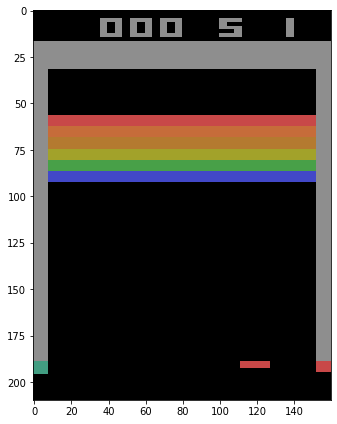

In [ ]:
# create environment and use wrapper to record the screen
test_env = gym.make('BreakoutDeterministic-v0')
test_env.reset()

# perform a random action
action = test_env.action_space.sample()
observation, reward, is_done, info = test_env.step(action)

# visualise the observation
plt.figure(figsize = (6,6))
plt.imshow(observation,cmap="gray")
plt.tight_layout()

- We observe:
  - Position of the paddle, ball and blocks
  - No information about the movements of game objects

- Proposed solution:
  - Generate a sequence of actions and observations


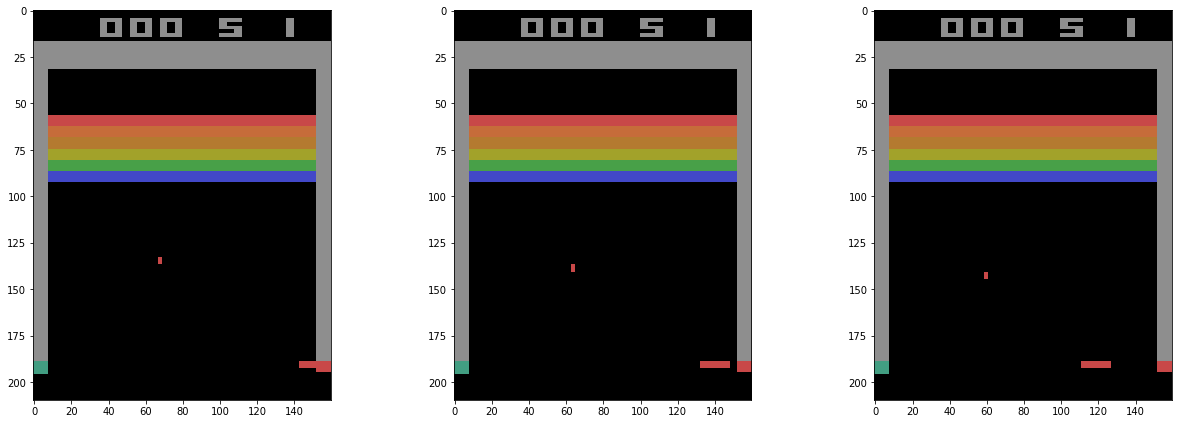

In [ ]:
seq_ = []

for step in range(3):
  # sample 3 consevtive observations
  action = test_env.action_space.sample()
  observation, reward, is_done, info = test_env.step(action)
  seq_.append(observation)

# visualise the sequence of observations
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,6))

ax[0].imshow(seq_[0],cmap="gray")
ax[1].imshow(seq_[1],cmap="gray")
ax[2].imshow(seq_[2],cmap="gray")
plt.tight_layout()

- Using above sequence:
  - Can determine the *direction, velocity and acceleration* of moving objects
  - **3 consecutive observations and actions** are sufficient
  - Take 4 observations just to be safe

> **In this MDP, each sequence *(last 4 observations & actions)* is a distinct state.**

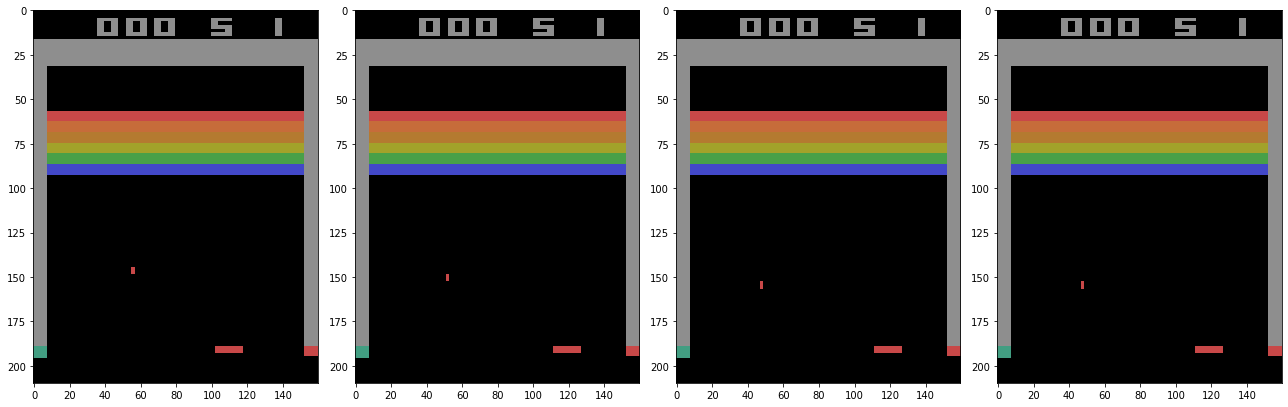

In [ ]:
seq_ = []

for step in range(4):
  # sample 3 consevtive observations
  action = test_env.action_space.sample()
  observation, reward, is_done, info = test_env.step(action)
  seq_.append(observation)

# visualise the sequence of observations
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(18,6))

ax[0].imshow(seq_[0],cmap="gray")
ax[1].imshow(seq_[1],cmap="gray")
ax[2].imshow(seq_[2],cmap="gray")
ax[3].imshow(seq_[2],cmap="gray")
plt.tight_layout()

---

### Image Preprocessing:

- Atari outputs *210x160* RGB arrays.


In [ ]:
print(f"Shape of the observation image: {observation.shape}")

Shape of the observation image: (210, 160, 3)


> Working directly with raw Atari frames, which are *210×160* pixel images with a 128 color palette, can be computationally demanding, so we apply a basic preprocessing step. 

> The raw frames are preprocessed by first converting their RGB representation to gray-scale and down-sampling it to a 110×84 image.

Shape of the observation image: (110, 84)


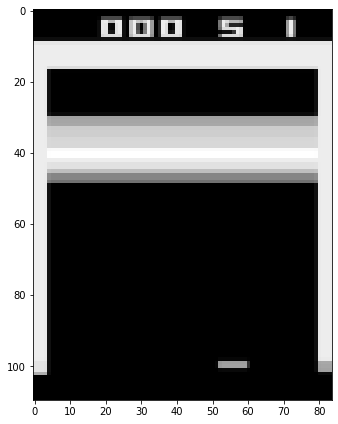

In [ ]:
def pre_process(observation):
    processed_observation = resize(rgb2gray(observation), (110, 84))
    return processed_observation

# visualise the observation
plt.figure(figsize = (6,6))
plt.imshow(pre_process(observation),cmap="gray")
plt.tight_layout()

print(f"Shape of the observation image: {pre_process(observation).shape}")

> The final input representation is obtained by cropping an 84×84 region of the image 

> The final cropping stage is only required because we use the GPU implementation of 2D convolutions

- Cropped image captures the playing area

Shape of the observation image: (84, 84)


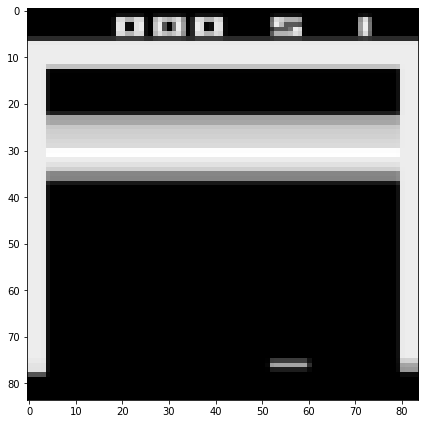

In [ ]:
def pre_process(observation):
    processed_observation = resize(rgb2gray(observation), (84, 84))
    return processed_observation

# visualise the observation
plt.figure(figsize = (6,6))
plt.imshow(pre_process(observation),cmap="gray")
plt.tight_layout()

print(f"Shape of the observation image: {pre_process(observation).shape}")

- Millions of such observations are used during NN training
- Therefore, I convert observation data from `float` to `integer` and store in `np.uint8` type
  - 8-bit-grey is the smallest possible information that can be held for each pixel *(produce 'monochrome' images)*

In [ ]:
print(f"Original preprocessed observation        : data_type : {pre_process(observation).dtype}, size: {pre_process(observation).nbytes} bytes")
print(f"Preprocessed observation with 'np.uint8' : data_type : {pre_process(observation).astype(np.uint8).dtype},   size:  {pre_process(observation).astype(np.uint8).nbytes} bytes")

Original preprocessed observation        : data_type : float64, size: 56448 bytes
Preprocessed observation with 'np.uint8' : data_type : uint8,   size:  7056 bytes


Shape of the observation image : (84, 84)
Size of the observation image  : 7056 bytes


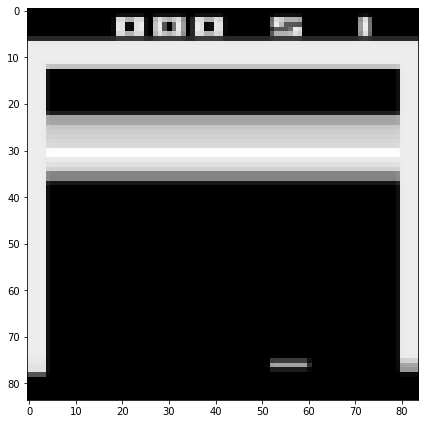

In [ ]:
def pre_process(observation):
    processed_observation = np.uint8(resize(rgb2gray(observation), (84, 84)) *255) #  gray scale image where pixel intensities are between 0-255
    return processed_observation

# visualise the observation
plt.figure(figsize = (6,6))
plt.imshow(pre_process(observation),cmap="gray")
plt.tight_layout()

print(f"Shape of the observation image : {pre_process(observation).shape}")
print(f"Size of the observation image  : {pre_process(observation).nbytes} bytes")

---
### Frame Skipping

- Each state contains the **'4' most recent observations** (*images)*
  - Only need to sample every 4th observation *(frame skipping)*
  - Can use an in-built function of `gym` environment
  - Instead of `GymEnvironmentDeterministic-v0`, need to used `GymEnvironmentDeterministic-v4`. That is:
    - `-v0` randomly skips 2, 3 or 4 frames.
    - `-v4` skips 4 frames.

- Last taken action is repeated over 4 frames

---
### Reward Clipping

> Since the scale of scores varies greatly from game to game, we fixed all positive rewards to be 1 and all negative rewards to be −1, leaving 0 rewards unchanged. 

> Clipping the rewards in this manner limits the scale of the error derivatives and makes it easier to use the same learning rate across multiple games

-  To make all environments similar to each other in rewards terms

In [ ]:
def clip_reward(reward):
  return np.sign(reward)

---

## RL Training Process

### Agent's Learning Goal

- At each state, idenfity the **action** that maximises the cummulative (discounted) future rewards at each sequence *(state)* (I.e., the **optimal policy**)
- In this paper $\rightarrow$ through **Q-learning**

- The optimal action-value function:

$$Q^{*}(s,a) = \max \mathbb{E}\left[ R_{t} | s_{t} = s, a_{t} = a\right]$$

- The optimal action-value function 
  - follows the **Bellman equation**
  - thus, can be solved by **Value iteration** algorithms

- Value iteration converges to the optimal action value function when $ Iterations \rightarrow \infty$


---
### Using NN as Action-value ($Q$) function approximator

- Large state space $\rightarrow$ cannot use tabular Q-function
- Use a **Neural Network (NN), a non-linear function approximator** to estimate the Q-network

#### NN model characteritics:

  - **Requirments** : 
    - be able to process image data (as input)
    - be able to produce action value estimates (as output)
  - **Input** : initial state ( 4 stacked preprocessed frames)
  - **Output** : action value estimate for the input state
      - Q-learning target: $r + \gamma \max_{a^\prime}Q_{i}(s^{\prime},a^{\prime})$ where;
        - $r$ - immediate reward recieved at initial state
        - $\gamma$ - discount factor
        - $\max_{a^\prime}Q_{i}(s^{\prime},a^{\prime})$ - max Q-value prediction for next state using current model weights

- **Training** : minimising a series of loss functions *(over many iterations for different actions)*
  - Loss: **mean squared error** over the **Q-values**:

  $$L_{i}(\theta_{i}) = \mathbb{E} \left[ \left( y_{i} - Q(s,a; \theta_{i})\right)^{2} \right],$$
    - where:
        - $i$ - iteration
        - $y_{i}$ - **target value** (output of NN | Q-learning target) 
        - $Q(s,a; \theta_{i})$ - current/observed action value estimate of the selected action


---

## Model Architecture

>The input to the neural network consists is an 84×84×4 image produced by $\Phi$. The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity. The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity. The final hidden layer is fully-connected and consists of 256 rectifier units. The output layer is a fully-connected linear layer with a single output for each valid action.

>In these experiments, we used the RMSProp algorithm with minibatches of size 32.


![DQN_Archit](https://drive.google.com/uc?id=1sd99TjN6VlJWpxrBt7orayneU6Z3ZXE7)



### Additional NN Input: **'Masked' Action Layer**

- For each input state:
  - NN outputs estimates for all actions
  - BUT the **loss** should ONLY be calculated for the **taken action**

- **Solution**:
  -  Multiply the outputs by a **'masked' input action layer**
  - 'masked' layer $\rightarrow$ one-hot encoded action
    - `1` for the taken action
    - `0` for all the remaining (non-taken) actions
  - Outputs x Mask =
    - `target = 0` for all non-taken actions *(thus, loss = 0)* 
    - Q-value updated only for taken action



In [ ]:
# function to generate one-hot-encoded masked action vector
def one_hot_encode_mask(target_action_idx, number_of_actions):
    return np.eye(number_of_actions)[np.array(target_action_idx).reshape(-1)]

In [ ]:
def q_approx_model():
    
    num_of_actions = 3 # number of agent actions
    input_img_size = (84, 84, 4)  # input image size to model

    # inputs to model
    obs_input = layers.Input(input_img_size, name='4_stacked_input_frames') 
    actions_input = layers.Input((num_of_actions,), name='one_hot_encoded_action_mask')

    # normalize the grayscaled 8bit input frames
    normalized_obs = layers.Lambda(lambda x: x / 255.0, name='frame_normalization')(obs_input)

    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    convolution_1 = layers.convolutional.Conv2D( 16, (8, 8), strides=(4, 4), activation='relu')(normalized_obs)

    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    convolution_2 = layers.convolutional.Conv2D( 32, (4, 4), strides=(2, 2), activation='relu')(convolution_1)

    # flattened second convolutional layer.
    convolution_2_flattened = layers.core.Flatten()(convolution_2)

    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    final_hidden = layers.Dense(256, activation='relu')(convolution_2_flattened)

    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output_layer = layers.Dense(num_of_actions, activation='linear')(final_hidden)

    # output multiplied by the mask
    masked_output = layers.Multiply(name='q_val')([output_layer, actions_input])

    # initialise the model
    model = Model(inputs = [obs_input, actions_input], outputs = masked_output)

    # model summary
    model.summary()

    # "We used the RMSProp algorithm""
    optimizer = RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    
    model.compile(optimizer, loss='mse')

    return model

---

## NN Training in a RL Setup

- In Reinforecement Learning:
  - Successive states are similar  *(thus, **highly correlated**)*
  - Training a NN only on consecutive samples is problematic:
    - slow learning -*insignificant difference between correlated data points*
    - NN forgets historical data
    - samples does not represent the complete population

- For NN training:
  - a representative sample of the underlying population *(which the learning algorithm tries to approximate)*
  - sample data points should be uncorrelated

### Proposed Solution: **Experience Replay**

  - **STEP 1** - At each iteration:
    - play one step of the game
    - observe information *(current state, taken action,  reward, next state, is next state terminal)*
    - store observed information in a fixed **Replay Memory** (last 1 million states)
  - **STEP 2** - After a fixed number of iterations:
    - randomly select a mini-batch (32 transitions) from the **Replay Memory**
    - train the Q-network using the selected mini-batch
      - minimise MSE error between Q-network estimates and observed targets (from mini-batch)

- Advantages:
  - Same experience used multiple times
  - Break correlation between samples (random sampling of mini-batch) 

- **Implementation Notes:**
  - To calculate $\max_{a^\prime}Q_{i}(s^{\prime},a^{\prime})$, I pass a mask of `1`s to predict action-value estimates for all actions
  - Instead of Q-target, assign `-1` if next state is terminal (explain model that termination is **worse**)


In [ ]:
# store the observed information in the replay memory
def store_replay_memory(replay_memory, current_state_set, action, reward, current_states_w_nxt_state, is_next_terminate):
    replay_memory.append((current_state_set, action, reward, current_states_w_nxt_state, is_next_terminate))

In [ ]:
# train the Q-network using random batches drawn from Replay Memory
def batch_train_q_network(replay_memory, model):

    num_of_actions = 3 # number of agent actions
    input_img_size = (84, 84, 4)  # input image size to model

    # batch size
    batch_size = 32

    # discounting factor (future reward decay rate)
    gamma = 0.99

    # draw a random mini-batch from the Replay Memory
    mini_batch = random.sample(replay_memory, batch_size)
    
    # create a placeholder to store `current state sets` from sampled batch
    current_states_set_history = np.zeros((batch_size, input_img_size[0]
                                                     , input_img_size[1]
                                                     , input_img_size[2]))
    
    # create a placeholder to store `current states with next states` from sampled batch
    current_states_set_w_nxt_history = np.zeros((batch_size, input_img_size[0]
                                                           , input_img_size[1]
                                                           , input_img_size[2]))
    
    # create a placeholder to store Q-value targets calculated during training 
    calculated_targets = np.zeros((batch_size,))

    # create placeholders to store actions, rewards and termination flags
    action, reward, is_next_terminate = [], [], []

    # transfer mini-batch data from Replay Memory to placeholders
    for idx, val in enumerate(mini_batch):
        current_states_set_history[idx] = val[0]
        action.append(val[1])
        reward.append(val[2])
        current_states_set_w_nxt_history[idx] = val[3]
        is_next_terminate.append(val[4])


    # generate next state Q-value estimates with current Q-network
    all_action_mask = np.ones((batch_size, num_of_actions))
    next_state_Q_values = model.predict([current_states_set_w_nxt_history, all_action_mask])

    # calculate target Q-values for sample using: r + gamma * max[Q(s',a')]
    # If next state is a terminal, set target to be -1 (negative reward - penalize termination)
    for i in range(batch_size):
        if is_next_terminate[i]:
            calculated_targets[i] = -1
        else:
            calculated_targets[i] = reward[i] + gamma * np.amax(next_state_Q_values[i])

    # create the mask layer for each selected action
    one_hot_encoded_action = one_hot_encode_mask(action, num_of_actions)

    # get target values only for the selected action
    one_hot_encoded_target = one_hot_encoded_action * calculated_targets[:, None]

    # train the q-network using mini-batch data
    H = model.fit([current_states_set_history, one_hot_encoded_action]
                  , one_hot_encoded_target
                  , epochs=1
                  , batch_size=batch_size
                  , verbose=0)

    # return the training loss
    return H.history['loss'][0]

### Action Selection Policy
- A stochastic policy is used
> The behavior policy during training was $\varepsilon$-greedy with $\varepsilon$ annealed linearly from 1 to 0.1 over the first million frames, and fixed at 0.1 thereafter.

- **Implementation Notes**:
  - Linearly annealed $\varepsilon$-greedy policy
      - start from : `1.0`
      - end at : `0.1`
      - annealed over : `500,000`  *(technical constraint)*

  - A random action is selected for `50,000` steps *(observation period - no training)*

In [ ]:
# select an action from the Q-network using an epsilon-greedy policy
def select_action(current_state_set, epsilon, step, model, obs_step_num):

    # select a random action (explore) if:
    ##   random value <= epsilon 
    ##     or
    ##   current step <= observation steps
    ## otherwise: select greedy action (action with max Q-value)

    # number of agent actions
    num_of_actions = 3

    if np.random.rand() <= epsilon or step <= obs_step_num:
        action = random.randrange(num_of_actions) # get the index of a random action
        return action + 1 # return the real action
    else:
        q_value = model.predict([current_state_set, np.ones(num_of_actions).reshape(1, num_of_actions)])
        action = np.argmax(q_value[0]) # get the index of the action with highest Q-value
        return action + 1 # return the real action

---
## Complete DQN Algorithm

- Putting all pieces together gives the DQN Algorithm

- **Implementation Notes**:
  - The fixed memory **Experience Replay** is implemented using `deque` container
      - Once the defined length is full, adding new items from one side pushes away items from the other side
  - One episode = one game
  - No training and $\varepsilon$-decaying over first `50,000` steps (accumulate data)
  - Target model weights are only updated at each `10,000` steps
    - Helps to avoid learned policy influence the future data
  - Due to technical constraints, different parameters used:
    - Training episodes : `1,000,000`
    - Experience Replay length : `200,000`
    - $\varepsilon$-decay length : `500,000`
  - Model weights are saved after every `500` episodes
    - If training is resumed: $\varepsilon$ begins from `0.5`




    

In [ ]:
# training and testing configurations:

configs = {  'train_dir'          : '/content/drive/My Drive/Projects/DQN/tf_train_breakout' # directory where to write event logs and checkpoint
            ,'restore_model_path' :  '/content/drive/My Drive/Projects/DQN/tf_train_breakout/breakout_model_20200229020040.h5' # Path of the restore model file
            ,'resume'             : False # resume training from previous a previous model
            }

In [ ]:
def dqn_algo_train():

    # create the Atari Breakout environment with frame skipping
    env = gym.make('BreakoutDeterministic-v4')

    # parameter initialization
    training_epi_limit = 1000000 # number of episodes to training the Q-network
    obs_step_num = 50000 # number of steps to observe (no training)
    replay_memory_len = 200000  # how many previous states to remember

    target_model_refresh_steps = 10000 # number of steps to refresh the target model weights

    inititial_epsilon = 1.0 # starting epsilon for the policy
    resume_epsilon = 0.5 # training resume epsilon for the policy 
    final_epsilon = 0.1 # final epsilon for the policy
    epsilon_annealed_steps = 500000 # number of steps to linearly anneal epsilon from 1.0 to 0.1

    epsilon_decay = (inititial_epsilon - final_epsilon) / epsilon_annealed_steps # epsilon decay per annealed step

    episode_num = 0 # store episode
    global_step_num = 0 # store global step number

    # initialize the fixed length Experience Replay memory
    memory = deque(maxlen = replay_memory_len)

    # initialize epsilon
    epsilon = inititial_epsilon
    
    # if DQN training is resumed from the last checkpoint
    # set a decayed (0.5) epsilon value to restrict exploration 
    # (assuming previous training sessions have done most exploration)
    if configs['resume']:
        model = load_model(configs['restore_model_path'])
        epsilon = resume_epsilon
    else:
        model = q_approx_model()

    # clone most recent Q-network to calculate target
    model_target = clone_model(model)
    model_target.set_weights(model.get_weights())

    # initialize the Q-learning episodes-loop
    while episode_num < training_epi_limit:

        # flags to identify if an episode/game has terminated
        terminated = False
  
        # variables to information per episode (a game)
        score = 0         # store game score (per episode/game)
        step = 0          # store steps taken (per episode/game)
        start_life = 5    # 1 episode/game has 5 lives       
        loss = 0.0        # store loss value per episode/game
        
        # reset the environment
        env.reset()

        # get the first observation and preprocess it
        first_obs, _, _, _ = env.step(1)
        first_state = pre_process(first_obs)

        # duplicate the first observations 4 times to create history
        history = np.stack((first_state, first_state, first_state, first_state), axis=2)
        history = np.reshape([history], (1, 84, 84, 4))

        # initialize a loop within an episode/game
        while not terminated:

            # get action for the current history and go one step in environment
            action = select_action(history, epsilon, global_step_num, model_target, obs_step_num)

            # decay epsilon after observation period
            if epsilon > final_epsilon and global_step_num > obs_step_num:
                epsilon -= epsilon_decay

            # record environment's response for the action
            observation, reward, terminated, info = env.step(action)

            # preprocess the observation and store as next state to new history
            next_state = pre_process(observation)
            next_state = np.reshape([next_state], (1, 84, 84, 1))
            next_history = np.append(next_state, history[:, :, :, :3], axis=3)

            # reward clipping
            reward = clip_reward(reward)

            # store the current step data to replay memory
            store_replay_memory(memory, history, (action-1), reward, next_history, terminated)

            # initiate the Q-network training if observation period is over
            if global_step_num > obs_step_num:

                # perform batch training for 1-epoch
                loss = loss + batch_train_q_network(memory, model)

                # update the target model weights every 10,000 steps
                if global_step_num % target_model_refresh_steps == 0:  
                    model_target.set_weights(model.get_weights())

            # update the in game/episode score
            score += reward

            # assign new state to current state
            history = next_history
            
            # increment the global step number and in game/episode step number
            global_step_num += 1
            step += 1

            # display information per episode/game at termination
            if terminated:
                print(f'episode: {episode_num}, score: {score}, global_step_num: {global_step_num}, avg loss: {loss/float(step)}, step: {step}, replay memory length: {len(memory)}')

                # save the model weights after every 500 episodes (and at the end of the training loop)
                if episode_num % 500 == 0 or (episode_num + 1) == training_epi_limit:
                    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
                    file_name = "breakout_model_{}.h5".format(now)
                    model_path = os.path.join(configs['train_dir'], file_name)
                    model.save(model_path)

                episode_num += 1


In [ ]:
dqn_algo_train()

### Training results:

In [ ]:
def dqn_algo_test(test_epi=1):
    # create the Atari Breakout environment with frame skipping
    env = gym.make('BreakoutDeterministic-v4')

    test_episodes = test_epi # number of episodes to run test

    # store the results 
    env = wrappers.Monitor(env, "/content/drive/My Drive/Projects/DQN/DQN_Test_Results", force=True)

    episode_number = 0 # initialize episode count
    epsilon = 0.001 # initialize epsilon - keep to minimum because no need to explore
    obs_step_num = 0 # no need to observe any data

    # to use the trained network
    global_step = 1000001  # 
    model = load_model(configs['restore_model_path'])

    # run the test game loop
    while episode_number < test_episodes:

        # flags to identify if an episode/game has terminated
        terminated = False

        # variables to information per episode (a game)
        score = 0         # store game score (per episode/game)
        start_life = 5    # 1 episode/game has 5 lives       
        
        # reset the environment
        env.reset()
        #observe = env.reset()

        # get the first observation and preprocess it
        first_obs, _, _, _ = env.step(1)
        first_state = pre_process(first_obs)

        # duplicate the first observations 4 times to create history
        history = np.stack((first_state, first_state, first_state, first_state), axis=2)
        history = np.reshape([history], (1, 84, 84, 4))

        # initialize a loop within an episode/game
        while not terminated:

            # get action for the current history and go one step in environment
            action = select_action(history, epsilon, global_step, model, obs_step_num)

            # record environment's response for the action
            observation, reward, terminated, info = env.step(action)

            # preprocess the observation and store as next state to new history
            next_state = pre_process(observation)
            next_state = np.reshape([next_state], (1, 84, 84, 1))
            next_history = np.append(next_state, history[:, :, :, :3], axis=3)

            # reward clipping
            reward = clip_reward(reward)

            # update the in game/episode score
            score += reward

            # assign new state to current state
            history = next_history

            # increment the global step number
            global_step += 1
            
            # store information at the episode termination
            if terminated:
                episode_number += 1
                print(f"episode: {episode_number}, score: {score}")
                env.close()
          

In [ ]:
dqn_algo_test(9)

episode: 1, score: 28.0
episode: 2, score: 28.0
episode: 3, score: 28.0
episode: 4, score: 28.0
episode: 5, score: 28.0
episode: 6, score: 28.0
episode: 7, score: 28.0
episode: 8, score: 28.0
episode: 9, score: 39.0


In [ ]:
# Saved video of agent's play
video = io.open('/content/drive/My Drive/Projects/DQN/DQN_Test_Results/openaigym.video.11.594.video000000.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="360" height="auto" alt="test_output" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))

### References:
- Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D. & Riedmiller, M. (2013). Playing Atari with Deep Reinforcement Learning.
- Weng, L., 2020. Implementing Deep Reinforcement Learning Models With Tensorflow + Openai Gym. [online] Lil'Log. Available at: <https://lilianweng.github.io/lil-log/2018/05/05/implementing-deep-reinforcement-learning-models.html>.
- GitHub. 2020. Openai Baselines: DQN. [online] Available at: <https://github.com/openai/baselines/blob/master/baselines/deepq/deepq.py>.
---
